## **Import Statements**

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## **Gaussian Filter Function**

In [2]:
def gaussian_filter(img, gaus_kernel_size=7, sigma=1, muu=0):
    x, y = np.meshgrid(np.linspace(-1, 1, gaus_kernel_size),
                       np.linspace(-1, 1, gaus_kernel_size))
    dst = np.sqrt(x**2 + y**2)
    normal = 1 / (((2 * np.pi)**0.5) * sigma)
    gauss = np.exp(-((dst - muu)**2 / (2.0 * sigma**2))) * normal
    gauss = np.pad(gauss, [(0, img.shape[0] - gauss.shape[0]), (0, img.shape[1] - gauss.shape[1])], 'constant')
    
    return gauss

## **Deblurring using Fourier Transform (Wiener Filter)**

In [3]:
def fft_deblur_channel(img, gaus_kernel_size=7, kernel_sigma=5, factor='wiener', const=0.002):
    
    gauss = gaussian_filter(img, gaus_kernel_size, kernel_sigma)
    
    img_fft = np.fft.fft2(img)
    gauss_fft = np.fft.fft2(gauss)
    weiner_factor = 1 / (1 + (const / np.abs(gauss_fft)**2))
    if factor != 'wiener':
        weiner_factor = factor
    recon = img_fft / gauss_fft
    recon *= weiner_factor
    recon = np.abs(np.fft.ifft2(recon))

    # Normalize to full 8-bit range [0, 255]
    recon = cv2.normalize(recon, None, 0, 255, cv2.NORM_MINMAX)
    
    return recon

In [4]:
def deblur_image(image, gaus_kernel_size=7, kernel_sigma=5, factor='wiener', const=0.5, brightness_factor=1.5):
    
    if len(image.shape) == 2:  # Grayscale image
        recon = fft_deblur_channel(image, gaus_kernel_size, kernel_sigma, factor, const)
    else:  # RGB image
        channels = cv2.split(image)
        recon_channels = [fft_deblur_channel(channel, gaus_kernel_size, kernel_sigma, factor, const) for channel in channels]
        recon = cv2.merge(recon_channels)

    # Apply brightness adjustment
    recon *= brightness_factor
    
    # Clip pixel values to [0, 255]
    recon = np.clip(recon, 0, 255)
    
    # Convert to uint8
    recon = np.clip(recon, 0, 255).astype(np.uint8)
    
    return recon

## **Gaussian Blurring**

In [5]:
def blur_image(image_path, blur_kernel_size=(7, 7), sigma=5):
    
    im = cv2.imread(image_path, -1)
    
    if len(im.shape) == 2:  # Grayscale image
        im_blur = cv2.GaussianBlur(im, blur_kernel_size, sigma)
    else:  # RGB image
        im_blur = cv2.GaussianBlur(im, blur_kernel_size, sigma)
    
    return im, im_blur

## **Sample Original and Gaussian Blurred Images**

In [6]:
# Path to the image
sample_image_path = 'image_1.jpg'

# Blur the image and display
sample_original_image, sample_blurred_image = blur_image(sample_image_path, blur_kernel_size=(7, 7), sigma=5)

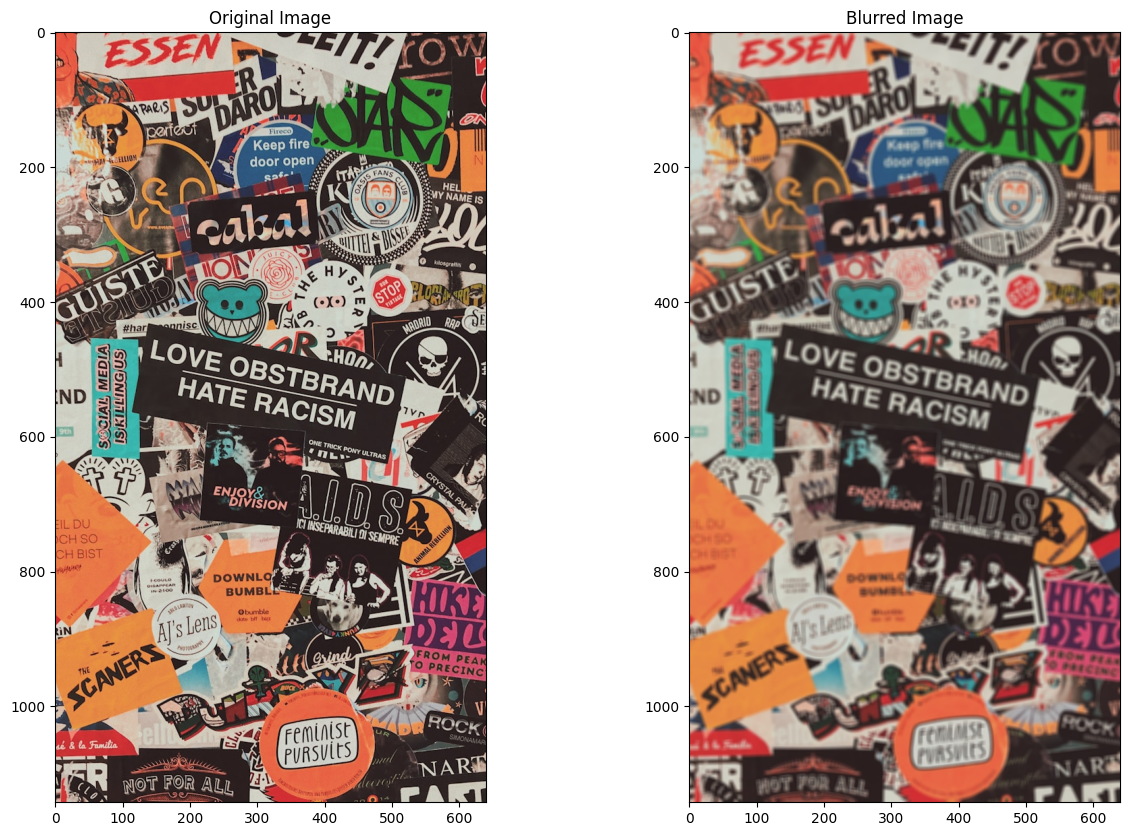

In [7]:
plt.figure(figsize=(15, 10))


plt.subplot(1, 2, 1)
if len(sample_original_image.shape) == 2:
    plt.imshow(sample_original_image, cmap='gray')
else:
    plt.imshow(cv2.cvtColor(sample_original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')


plt.subplot(1, 2, 2)
if len(sample_blurred_image.shape) == 2:
    plt.imshow(sample_blurred_image, cmap='gray')
else:
    plt.imshow(cv2.cvtColor(sample_blurred_image, cv2.COLOR_BGR2RGB))
plt.title('Blurred Image')

          
plt.show()

## **Sample Gaussian Blurred and Deblurred Images**

In [8]:
# Deblur the image and display
sample_deblurred_image = deblur_image(sample_blurred_image, gaus_kernel_size=7, kernel_sigma=5, factor='wiener', const=0.1, brightness_factor=2.0)

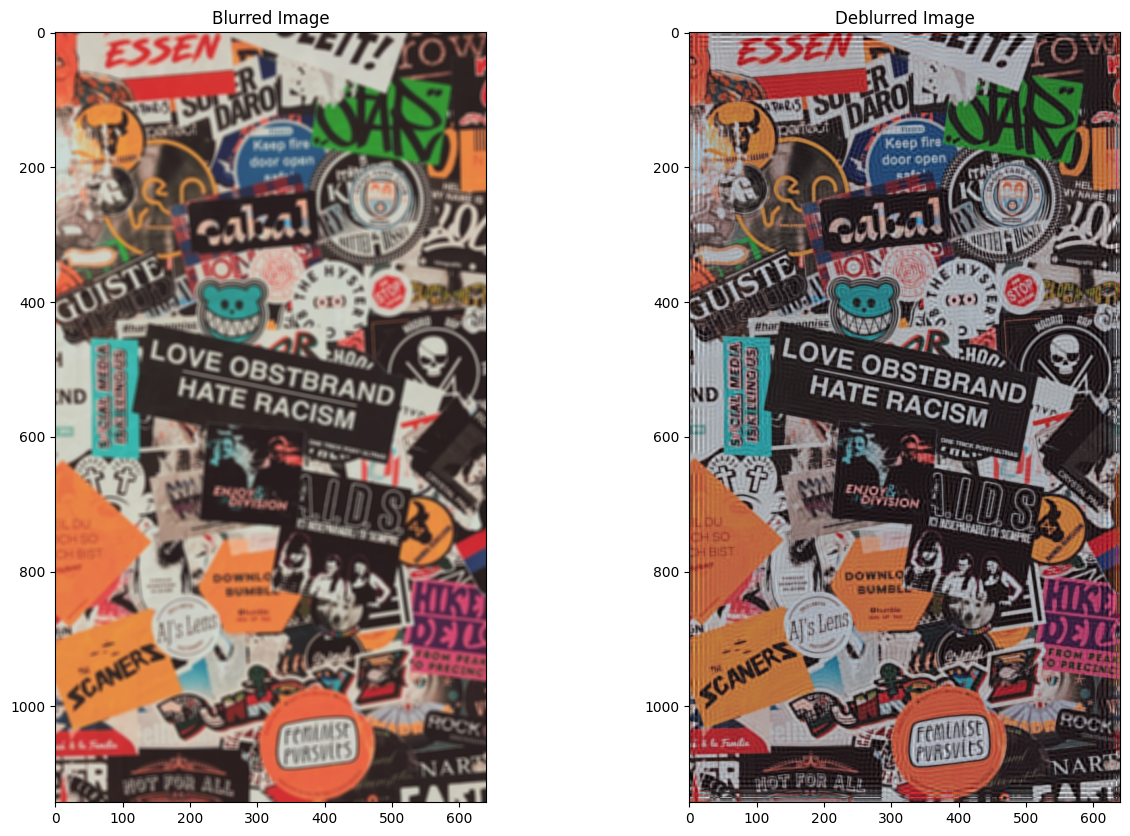

In [9]:
plt.figure(figsize=(15, 10))


plt.subplot(1, 2, 1)
if len(sample_blurred_image.shape) == 2:
    plt.imshow(sample_blurred_image, cmap='gray')
else:
    plt.imshow(cv2.cvtColor(sample_blurred_image, cv2.COLOR_BGR2RGB))
plt.title('Blurred Image')


plt.subplot(1, 2, 2)
if len(sample_deblurred_image.shape) == 2:
    plt.imshow(sample_deblurred_image, cmap='gray')
else:
    plt.imshow(cv2.cvtColor(sample_deblurred_image, cv2.COLOR_BGR2RGB))
plt.title('Deblurred Image')


plt.show()

## **Function to Read Image**

In [10]:
def read_image(path):
    im = cv2.imread(path, -1)
    
    return im

## **Function to Blur a Normal Image**

In [11]:
def blur_input_image(normal_image_path, blur_kernel_size=(7, 7), sigma=5):
    
    normal_image = read_image(normal_image_path)
    
    im_blur = cv2.GaussianBlur(normal_image, blur_kernel_size, sigma)
    
    return im_blur

## **Function to Deblur a Gaussian-Blurred Image**

In [12]:
def deblur_artificially_blurred_image(normal_image_path, blur_kernel_size=(7, 7), gaus_kernel_size=7, kernel_sigma=5, factor='wiener', const=0.002, brightness_factor = 1.5):
    
    artifically_blurred_image = blur_input_image(normal_image_path, blur_kernel_size, kernel_sigma)
    
    if len(artifically_blurred_image.shape) == 2:  # Grayscale image
        recon = fft_deblur_channel(artifically_blurred_image, gaus_kernel_size, kernel_sigma, factor, const)
    else:  # RGB image
        channels = cv2.split(artifically_blurred_image)
        recon_channels = [fft_deblur_channel(channel, gaus_kernel_size, kernel_sigma, factor, const) for channel in channels]
        recon = cv2.merge(recon_channels)

    # Apply brightness adjustment
    recon *= brightness_factor
    
    # Convert to uint8
    recon = np.clip(recon, 0, 255).astype(np.uint8)
    
    return recon

## **Function to Deblur an Originally Blurred Image**

In [13]:
def deblur_originally_blurred_image(originally_blurred_image_path, gaus_kernel_size=7, kernel_sigma=5, factor='wiener', const=0.002, brightness_factor = 1.5):
    
    originally_blurred_image = read_image(originally_blurred_image_path)
    
    if len(originally_blurred_image.shape) == 2:  # Grayscale image
        recon = fft_deblur_channel(originally_blurred_image, gaus_kernel_size, kernel_sigma, factor, const)
    else:  # RGB image
        channels = cv2.split(originally_blurred_image)
        recon_channels = [fft_deblur_channel(channel, gaus_kernel_size, kernel_sigma, factor, const) for channel in channels]
        recon = cv2.merge(recon_channels)

    # Apply brightness adjustment
    recon *= brightness_factor
    
    # Convert to uint8
    recon = np.clip(recon, 0, 255).astype(np.uint8)
    
    return recon

## **Original and Corresponding Gaussian-Blurred and Deblurred Images**

In [14]:
deblurred_artificially_blurred_image = deblur_artificially_blurred_image('image_3.jpg', const=0.1)

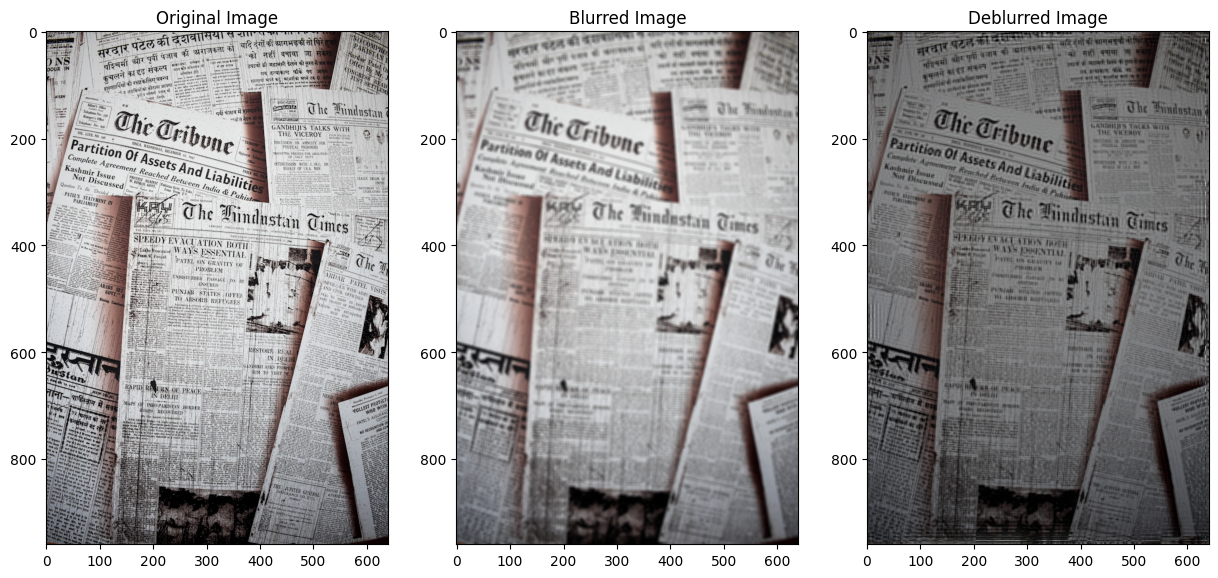

In [15]:
original_image_path = 'image_3.jpg'
oim = cv2.imread(original_image_path, -1)


plt.figure(figsize=(15, 10))


plt.subplot(1, 3, 1)
if len(oim.shape) == 2:
    plt.imshow(oim, cmap='gray')
else:
    plt.imshow(cv2.cvtColor(oim, cv2.COLOR_BGR2RGB))
plt.title('Original Image')


plt.subplot(1, 3, 2)
blurred_image = blur_input_image(original_image_path)
if len(blurred_image.shape) == 2:
    plt.imshow(blurred_image, cmap='gray')
else:
    plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
plt.title('Blurred Image')


plt.subplot(1, 3, 3)
if len(deblurred_artificially_blurred_image.shape) == 2:
    plt.imshow(deblurred_artificially_blurred_image, cmap='gray')
else:
    plt.imshow(cv2.cvtColor(deblurred_artificially_blurred_image, cv2.COLOR_BGR2RGB))
plt.title('Deblurred Image')


plt.show()

## **Originally Blurred and Deblurred Images**

In [16]:
deblurred_originally_blurred_image = deblur_originally_blurred_image('image_2.png', 7, 5, 'wiener', 0.5)

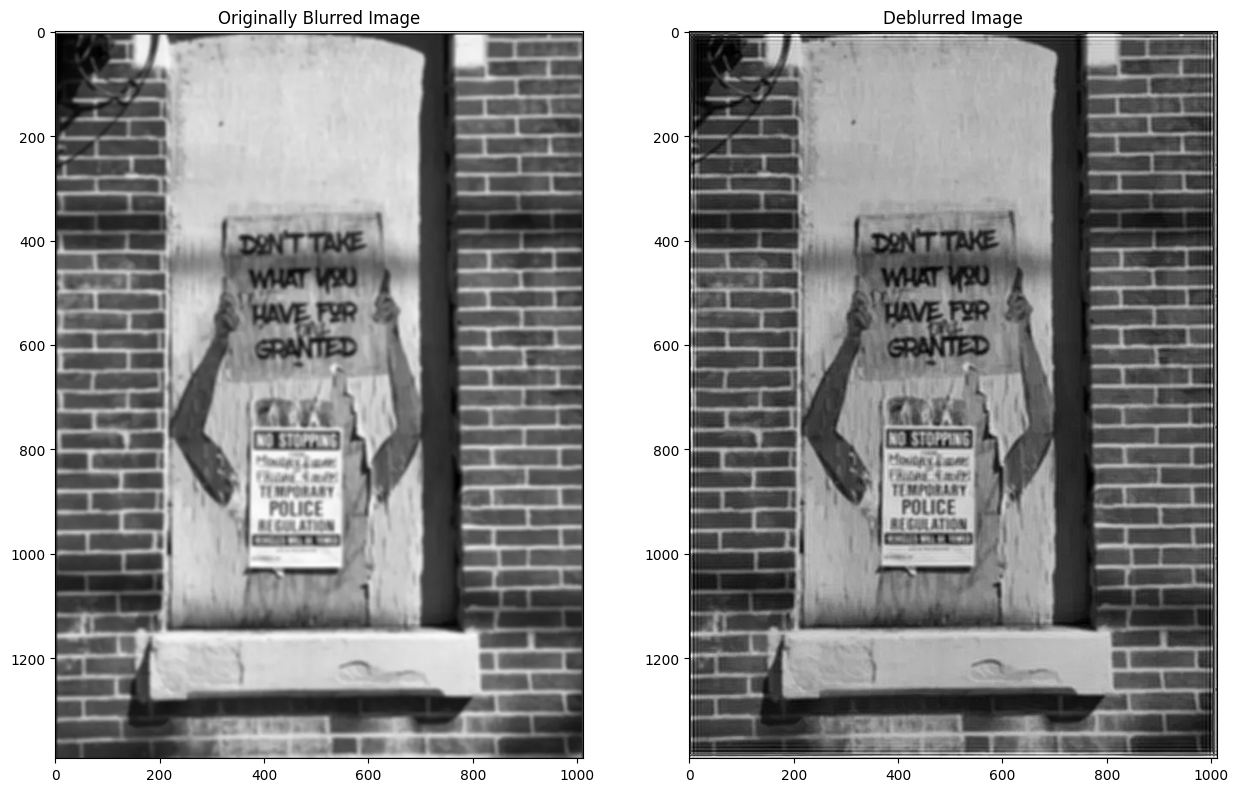

In [17]:
originally_blurred_image_path = 'image_2.png'
obim = cv2.imread(originally_blurred_image_path, -1)


plt.figure(figsize=(15, 10))


plt.subplot(1, 2, 1)
if len(obim.shape) == 2:
    plt.imshow(obim, cmap='gray')
else:
    plt.imshow(cv2.cvtColor(obim, cv2.COLOR_BGR2RGB))
plt.title('Originally Blurred Image')


plt.subplot(1, 2, 2)
if len(deblurred_originally_blurred_image.shape) == 2:
    plt.imshow(deblurred_originally_blurred_image, cmap='gray')
else:
    plt.imshow(cv2.cvtColor(deblurred_originally_blurred_image, cv2.COLOR_BGR2RGB))
plt.title('Deblurred Image')


plt.show()